# Xboost Model

## Load libraries

In [1]:
# Importar librerías que vamos a estar usando en general 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, trange
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Importar funcions per evaluar els models
from utils import evaluate_models
from utils import plot_model_evaluation

## Load data

In [2]:
pth = "../"

df_20 = pd.read_csv(os.path.join(pth, "full_data_2020.csv"), index_col=False, skipinitialspace=True, skip_blank_lines=True)
df_21 = pd.read_csv(os.path.join(pth, "full_data_2021.csv"), index_col=False, skipinitialspace=True, skip_blank_lines=True)
df_22 = pd.read_csv(os.path.join(pth, "full_data_2022.csv"), index_col=False, skipinitialspace=True, skip_blank_lines=True)
df_23 = pd.read_csv(os.path.join(pth, "full_data_2023.csv"), index_col=False, skipinitialspace=True, skip_blank_lines=True)
df = pd.concat([df_20, df_21, df_22, df_23], ignore_index = True)

if 'Unnamed: 0' in df.columns:
    df = df.drop(['Unnamed: 0'], axis=1)   # Eliminar columna Unnamed

# Visualitzar el df
df.head()

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage_docks_available,...,altitude,post_code,capacity,mm_precip,temperature,rating,ocio,carriles,time,festius
0,1.0,2020,1.0,1.0,2.0,0.522727,0.503788,0.469697,0.403409,0.354167,...,16.0,8013,45,0.0,5.75,6.0,88.0,6.0,2,1
1,1.0,2020,1.0,1.0,7.0,0.289773,0.373106,0.304924,0.238636,0.240530,...,16.0,8013,45,0.0,4.25,6.0,88.0,6.0,7,1
2,1.0,2020,1.0,1.0,12.0,0.253788,0.268939,0.350379,0.344697,0.393939,...,16.0,8013,45,0.0,12.45,6.0,88.0,6.0,12,1
3,1.0,2020,1.0,1.0,17.0,0.390152,0.346591,0.255814,0.220930,0.186047,...,16.0,8013,45,0.0,9.35,6.0,88.0,6.0,17,1
4,1.0,2020,1.0,1.0,22.0,0.083333,0.218992,0.437984,0.515504,0.470930,...,16.0,8013,45,0.0,6.80,6.0,88.0,6.0,22,1


In [3]:
test_data = pd.read_csv("../full_data_2024.csv")
test_data.drop(['percentage_docks_available'], axis=1, inplace=True)
test_data.head()    

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,lat,...,altitude,post_code,capacity,mm_precip,temperature,rating,ocio,carriles,time,festius
0,1.0,2024,1.0,1.0,5.0,0.781481,0.677778,0.696296,0.750000,41.397978,...,16.0,8013,45,0.0,8.85,6.0,88.0,6.0,35069,1
1,1.0,2024,1.0,1.0,10.0,0.737374,0.711111,0.711111,0.731624,41.397978,...,16.0,8013,45,0.0,11.15,6.0,88.0,6.0,35074,1
2,1.0,2024,1.0,1.0,15.0,0.827778,0.896296,0.901852,0.883333,41.397978,...,16.0,8013,45,0.0,12.70,6.0,88.0,6.0,35079,1
3,1.0,2024,1.0,1.0,20.0,0.825926,0.874074,0.927778,0.918519,41.397978,...,16.0,8013,45,0.0,8.35,6.0,88.0,6.0,35084,1
4,1.0,2024,1.0,2.0,1.0,0.712963,0.777778,0.814815,0.790741,41.397978,...,16.0,8013,45,0.0,9.05,6.0,88.0,6.0,35089,0


In [4]:
# Separar les característiques (X) de la variable objectiu (y)
X = df.drop(['percentage_docks_available'], axis=1)
y = df['percentage_docks_available']

In [5]:
# Dividim les dades en conjunts de training i testing
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Encoding
cat_cols = ['station_id', 'post_code']#, 'month', 'day', 'year']
x_train_encoded = pd.get_dummies(X_train, columns=cat_cols)
x_validation_encoded = pd.get_dummies(X_validation, columns=cat_cols)

x_test_encoded = pd.get_dummies(test_data, columns=cat_cols)

In [7]:
# Veiem si el training set y el TEST SET 2024 tenen diferent número de columnes després del encoding. Mirem quines son les columnes que falten al set de 2024.
missing_cols = set(x_train_encoded.columns) - set(x_test_encoded.columns)
print("Missing columns in validation set:", missing_cols)

# Si hay columnas que faltan en el TEST set, las borramos del training set y del validation set
for col in missing_cols:
    x_train_encoded.drop(col, axis=1, inplace=True)
    x_validation_encoded.drop(col, axis=1, inplace=True)

print("Training set shape after deleting columns:", x_train_encoded.shape)
print("Validation set shape:", x_validation_encoded.shape)
print("Test set shape:", x_test_encoded.shape)

Missing columns in validation set: {'station_id_515.0', 'station_id_452.0', 'station_id_441.0', 'station_id_96.0', 'station_id_485.0', 'station_id_461.0', 'station_id_366.0', 'station_id_503.0', 'station_id_502.0', 'station_id_444.0', 'station_id_510.0', 'station_id_493.0', 'station_id_505.0', 'station_id_517.0', 'station_id_511.0', 'station_id_355.0', 'post_code_8035', 'station_id_450.0', 'station_id_440.0', 'station_id_454.0', 'station_id_287.0', 'station_id_480.0', 'station_id_508.0', 'station_id_509.0', 'station_id_447.0', 'station_id_481.0', 'station_id_442.0', 'station_id_497.0', 'station_id_501.0', 'station_id_463.0', 'station_id_445.0', 'station_id_518.0', 'station_id_91.0', 'station_id_433.0', 'station_id_462.0', 'station_id_460.0', 'station_id_464.0', 'station_id_504.0', 'station_id_422.0', 'station_id_443.0', 'station_id_449.0', 'station_id_77.0', 'station_id_52.0', 'station_id_507.0', 'station_id_330.0', 'station_id_513.0', 'station_id_411.0', 'post_code_8023', 'station_id_

# Normalitzar les dades -peta
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train_encoded_scal = scaler.fit_transform(x_train_encoded)
x_validation_encoded_scal = scaler.fit_transform(x_validation_encoded)

print("Training set shape:", x_train_encoded_scal.shape)
print("Validation set shape:", x_validation_encoded_scal.shape)

## Model XGBOOST

In [8]:
# Creem model de XGBoost Regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

xgbr = XGBRegressor(n_estimators=300, learning_rate=0.05, n_jobs=10)

xgbr.fit(x_train_encoded, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=10,
             num_parallel_tree=None, random_state=None, ...)

In [9]:
y_pred_xgbr = xgbr.predict(x_validation_encoded)

mse = mean_squared_error(y_validation, y_pred_xgbr)
rmse = mean_squared_error(y_validation, y_pred_xgbr, squared=False)
mae = mean_absolute_error(y_validation, y_pred_xgbr)
r2 = r2_score(y_validation, y_pred_xgbr)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)

MSE: 0.011491696492519977
RMSE: 0.10719933065332067
MAE: 0.06870862555717427
R2: 0.8585248387308931


In [10]:
# Evaluem el model
results = evaluate_models(y_validation, y_pred_xgbr)
print(results)

{'Mean Squared Error': 0.011491696492519977, 'Mean Absolute Error': 0.06870862555717427, 'R2 Score': 0.8585248387308931}


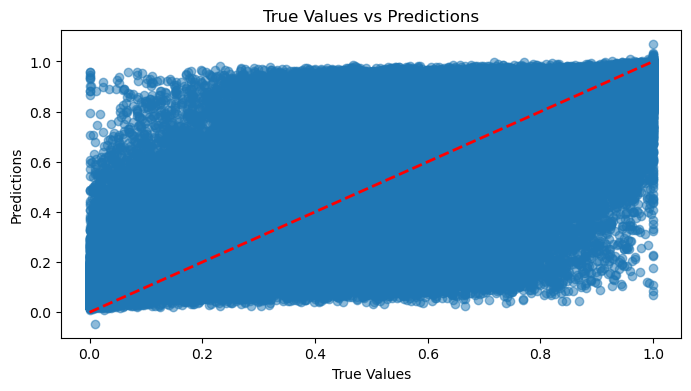

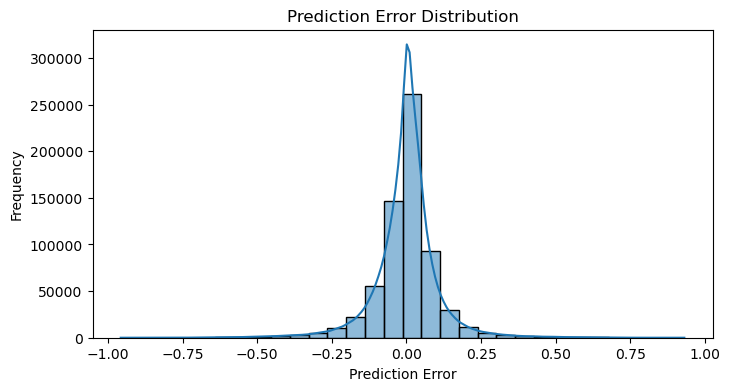

In [11]:
# Evaluem el model
plot_model_evaluation(y_validation, y_pred_xgbr)

In [ ]:
# Feature importance FALTA PROVAR, NOMÉS CODI
# NO VAAAAA
plt.figure(figsize=(10, 6))
plt.barh(x_train_encoded.columns, xgbr.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance XGBoost Regression')
plt.show()

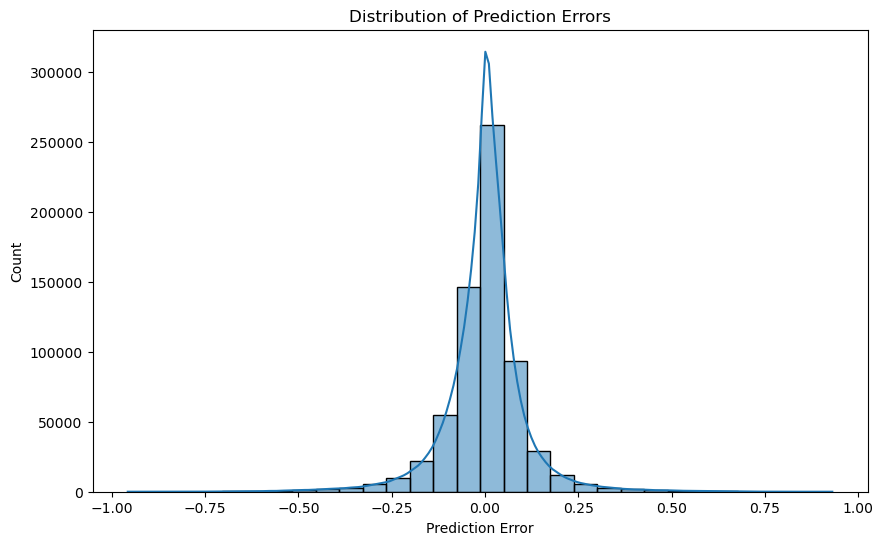

In [12]:
import seaborn as sns

# Histograma dels errors
errors = y_validation - y_pred_xgbr
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel('Prediction Error')
plt.title('Distribution of Prediction Errors')
plt.show()

# Predicció 2024

In [13]:
x_test_encoded.head()

,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,lat,lon,...,post_code_8032,post_code_8033,post_code_8034,post_code_8036,post_code_8037,post_code_8038,post_code_8039,post_code_8041,post_code_8042,post_code_8930
0,2024,1.0,1.0,5.0,0.781481,0.677778,0.696296,0.750000,41.397978,2.180107,...,0,0,0,0,0,0,0,0,0,0
1,2024,1.0,1.0,10.0,0.737374,0.711111,0.711111,0.731624,41.397978,2.180107,...,0,0,0,0,0,0,0,0,0,0
2,2024,1.0,1.0,15.0,0.827778,0.896296,0.901852,0.883333,41.397978,2.180107,...,0,0,0,0,0,0,0,0,0,0
3,2024,1.0,1.0,20.0,0.825926,0.874074,0.927778,0.918519,41.397978,2.180107,...,0,0,0,0,0,0,0,0,0,0
4,2024,1.0,2.0,1.0,0.712963,0.777778,0.814815,0.790741,41.397978,2.180107,...,0,0,0,0,0,0,0,0,0,0


In [14]:
x_train_encoded.head()

,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,lat,lon,...,post_code_8032,post_code_8033,post_code_8034,post_code_8036,post_code_8037,post_code_8038,post_code_8039,post_code_8041,post_code_8042,post_code_8930
511033,2020,2.0,15.0,17.0,0.842949,0.743590,0.666667,0.573718,41.375942,2.129954,...,0,0,0,0,0,0,0,0,0,0
1191015,2021,4.0,22.0,10.0,0.894824,0.842593,0.876187,0.879630,41.426078,2.175157,...,0,0,0,0,0,0,0,0,0,0
3170720,2023,3.0,14.0,9.0,0.884259,0.699074,0.412037,0.388889,41.438312,2.203982,...,0,0,0,0,0,0,0,0,0,0
2188743,2022,4.0,5.0,6.0,0.656250,0.656250,0.643229,0.575605,41.376520,2.178810,...,0,0,0,0,0,0,1,0,0,0
876781,2021,10.0,1.0,0.0,0.759259,0.867521,0.918519,0.939815,41.389492,2.174250,...,0,0,0,0,0,0,0,0,0,0


In [15]:
predictions_xgbr = xgbr.predict(x_test_encoded)

In [17]:
import datetime
data = pd.DataFrame({"index": range(len(predictions_xgbr)), "percentage_docks_available": predictions_xgbr})
now = datetime.datetime.now()
timestamp = now.strftime("%m_%d_%H_%M")  # mes_dia_hora_min
filename = f"data/results/predictions_{timestamp}_xgbr.csv"

data.to_csv(filename, index=False)